# Prosper Decision Tree Model Example

This demonstrates a simple decision tree model to predict defaults on Prosper data

In [1]:
pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import sklearn.tree as tree
import sklearn.metrics as metrics
import pickle

### Load data, inspect, subset to columns and loan terms of interest, format

In [3]:
#load and inspect
loans = pd.read_csv(r'prosper_short.csv', low_memory=False)
loans.head()

,loan_number,amount_borrowed,borrower_rate,prosper_rating,term,age_in_months,origination_date,days_past_due,principal_balance,service_fees_paid,...,CV21,CV22,CV23,CV24,TUFicoRange,TUFicoDate,dti_wprosper_loan,CoBorrowerApplication,CombinedDtiwProsperLoan,CombinedStatedMonthlyIncome
0,254354,12000.0,0.1526,C,60,72,2015-01-02 00:00:00.000,0,0.0,-165.35,...,NaN,NaN,NaN,NaN,NaN,NaN,0.13,False,NaN,NaN
1,254360,6000.0,0.0819,A,36,72,2015-01-02 00:00:00.000,0,0.0,-96.14,...,NaN,NaN,NaN,NaN,NaN,NaN,0.24,False,NaN,NaN
2,254369,18000.0,0.1373,B,60,72,2015-01-02 00:00:00.000,0,0.0,-58.12,...,NaN,NaN,NaN,NaN,NaN,NaN,0.29,False,NaN,NaN
3,254372,3636.0,0.0819,A,36,72,2015-01-02 00:00:00.000,0,0.0,-3.19,...,NaN,NaN,NaN,NaN,NaN,NaN,0.15,False,NaN,NaN
4,254375,3000.0,0.2181,D,60,72,2015-01-02 00:00:00.000,0,0.0,-67.26,...,NaN,NaN,NaN,NaN,NaN,NaN,0.37,False,NaN,NaN


In [4]:
#Get just 3 yr loans
loans = loans.loc[loans['term']==36]
#Subset to columns of interest
loans = loans[['loan_number', 'loan_status_description', 'origination_date', 'amount_borrowed', 'listing_monthly_payment', 
               'borrower_rate', 'stated_monthly_income', 'dti_wprosper_loan', 'occupation', 'prosper_rating']]
#Make defaulted dummy column and throw away unresolved/cancelled loans so we are only looking at 
#loans that payoff in full or default for sure
loans['defaulted'] = 0
loans.loc[loans['loan_status_description']=='CHARGEOFF', 'defaulted'] = 1
loans.loc[loans['loan_status_description']=='DEFAULTED', 'defaulted'] = 1
loans.loc[loans['loan_status_description']=='CURRENT', 'defaulted'] = -1
loans.loc[loans['loan_status_description']=='CANCELLED', 'defaulted'] = -1
loans = loans.loc[loans['defaulted']>= 0]
#winsorize dti outliers (not super-important for decision tree)
loans.loc[loans['dti_wprosper_loan'] > loans['dti_wprosper_loan'].quantile(0.95), 'dti_wprosper_loan'] = loans['dti_wprosper_loan'].quantile(0.95)
#add payment-to-income ratio
loans.loc[loans['stated_monthly_income']<=0, 'stated_monthly_income'] = 1.0
loans['pti'] = loans['listing_monthly_payment']/loans['stated_monthly_income']
#add occupation dummies
occ_dummies = pd.get_dummies(loans['occupation'])
occ_dummies.head()
#merge dummies back into loans and fix names on some of the dummies
loans = pd.merge(loans, occ_dummies, how='inner', left_index=True, right_index=True)
loans['Accountant_CPA'] = loans['Accountant/CPA']
loans['Food_Service'] = loans['Food Service']
#Format dates and sort
loans['origination_date'] = pd.to_datetime(loans['origination_date'])
loans = loans.sort_values('origination_date')
loans = loans.reset_index(drop=True)
#keep just loans originated in 2015 for in-sample model
loans['orig_year'] = loans['origination_date'].dt.year
loans = loans.loc[loans['orig_year']==2015]

In [5]:
#Add a new variable - this time we will turn the Prosper rating into an ordered categorical value 
ratings = ['AA','A','B','C','D','E','HR']
category_rating = pd.api.types.CategoricalDtype(categories=ratings, ordered=True)
loans['prosper_rating'] = loans['prosper_rating'].astype(category_rating)
loans['nrating'] = pd.Categorical(loans['prosper_rating']).codes

In [6]:
#subset to just columns to be used in model
loans = loans[['defaulted', 'amount_borrowed', 'listing_monthly_payment', 'borrower_rate', 'stated_monthly_income', 
               'dti_wprosper_loan', 'pti', 'nrating', 'Executive', 'Other', 'Clerical', 'Accountant_CPA', 'Food_Service']]
loans.head()

,defaulted,amount_borrowed,listing_monthly_payment,borrower_rate,stated_monthly_income,dti_wprosper_loan,pti,nrating,Executive,Other,Clerical,Accountant_CPA,Food_Service
0,0,6000.0,188.54,0.0819,2083.3333,0.24,0.090499,1,False,False,False,False,False
1,0,2000.0,62.85,0.0819,1541.6667,0.16,0.040768,1,False,False,False,False,False
2,0,3000.0,91.58,0.0623,3750.0000,0.27,0.024421,0,False,False,False,False,False
3,0,12000.0,408.56,0.1373,8333.3333,0.19,0.049027,2,False,False,False,False,False
4,0,25000.0,817.88,0.1095,8083.3333,0.30,0.101181,1,False,False,False,False,False


In [7]:
#count missing values
loans.isnull().sum()

defaulted                  0
amount_borrowed            0
listing_monthly_payment    0
borrower_rate              0
stated_monthly_income      0
dti_wprosper_loan          0
pti                        0
nrating                    0
Executive                  0
Other                      0
Clerical                   0
Accountant_CPA             0
Food_Service               0
dtype: int64

## Decision tree model

In [8]:
Y = loans['defaulted'].values
Y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [9]:
X = loans[['amount_borrowed', 'listing_monthly_payment', 'borrower_rate', 'stated_monthly_income', 'dti_wprosper_loan', 
           'pti', 'nrating', 'Executive', 'Other', 'Clerical', 'Accountant_CPA', 'Food_Service']].values
X

array([[6000.0, 188.54, 0.0819, ..., False, False, False],
       [2000.0, 62.85, 0.0819, ..., False, False, False],
       [3000.0, 91.58, 0.0623, ..., False, False, False],
       ...,
       [8000.0, 256.86, 0.0966, ..., False, False, False],
       [5000.0, 152.22, 0.0605, ..., False, False, False],
       [15000.0, 523.14, 0.1543, ..., False, False, False]], dtype=object)

In [10]:
#Note: The tree depth is currently set to 4 so we can visualize the tree reasonably well. But it doesn't perform well for classification.
# Try again with a deeper tree to see if it will work better.
#clf = tree.DecisionTreeClassifier()
#clf = tree.DecisionTreeClassifier(max_depth = 15)
clf = tree.DecisionTreeClassifier(max_depth = 4)
clf = clf.fit(X, Y)

In [11]:
# Which variables are most important?
clf.feature_importances_

array([0.        , 0.01316139, 0.74012903, 0.10239512, 0.        ,
       0.14431445, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [12]:
clf.get_depth()

4

In [13]:
# Save the trained model in a format that will let other programs load it directly
#Note: dropping data makes it much smaller if you don't need it anymore
pickle.dump(clf, open('DTree1.pkl', 'wb'))

### What does the tree look like?  

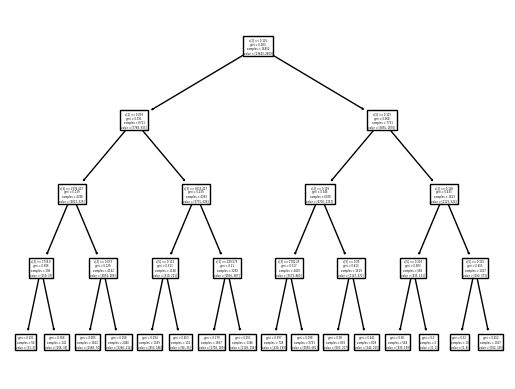

In [14]:
#This uses the new scikit-learn plotting functions. Not very useful!
fig = tree.plot_tree(clf)

This uses graphviz, if you don't have it setup on your computer and you can't see the image below, you can still take the sample output file "tree.dot" and past into the web app at http://webgraphviz.com to see.

In [15]:
import graphviz
import pydotplus
import six
import IPython.display as disp

In [16]:
dot_data = six.StringIO()
tree.export_graphviz(clf, out_file=dot_data, feature_names =['amount_borrowed', 'listing_monthly_payment', 'borrower_rate', 
            'stated_monthly_income', 'dti_wprosper_loan', 'pti', 'nrating', 'Executive', 'Other', 'Clerical', 'Accountant_CPA', 'Food_Service'],  
                filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [19]:
disp.Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [17]:
#This version creates a .png image file
graph.write_png('tree.png')

InvocationException: GraphViz's executables not found

### Some classification performance analysis:

In [18]:
# Get the predicted values out of the model and assign to a variable
predicted = clf.predict(X)
predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [19]:
#accuracy score
metrics.accuracy_score(Y, predicted)

0.8297471432044736

In [20]:
#classification report
print(metrics.classification_report(Y, predicted))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91     13643
           1       0.83      0.00      0.01      2809

    accuracy                           0.83     16452
   macro avg       0.83      0.50      0.46     16452
weighted avg       0.83      0.83      0.75     16452



In [21]:
#confusion matrix
#format: rows broken down by true values, columns broken down by predicted values
#This means the first row has all loans that actually payoff, the second row has all loans that actually default, etc.
#NOTE: to discuss in class, perfect prediction in sample is probably bad!
print(metrics.confusion_matrix(Y, predicted))

[[13641     2]
 [ 2799    10]]


ROC/AUC analysis

In [22]:
#First we need probabilites instead of discrete classifications
pred = clf.predict_proba(X)
pred

array([[0.75714286, 0.24285714],
       [0.94642857, 0.05357143],
       [0.95547533, 0.04452467],
       ...,
       [0.82098171, 0.17901829],
       [0.95547533, 0.04452467],
       [0.81747521, 0.18252479]])

In [23]:
pred[:,1]

array([0.24285714, 0.05357143, 0.04452467, ..., 0.17901829, 0.04452467,
       0.18252479])

In [24]:
#In sample ROC curve
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = metrics.roc_curve(loans['defaulted'].values, pred[:,1])
# AUC = Area Under (ROC) Curve - a good performance measure
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6762204562997332

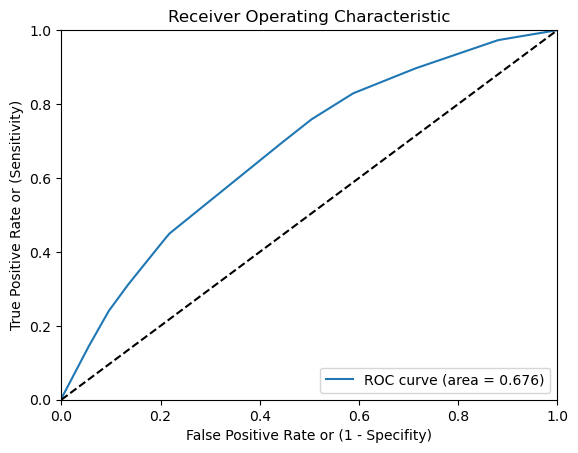

In [25]:
# Plot ROC curve
pylab.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
pylab.plot([0, 1], [0, 1], 'k--')  # random predictions curve
pylab.xlim([0.0, 1.0])
pylab.ylim([0.0, 1.0])
pylab.xlabel('False Positive Rate or (1 - Specifity)')
pylab.ylabel('True Positive Rate or (Sensitivity)')
pylab.title('Receiver Operating Characteristic')
pylab.legend(loc="lower right")

The classification looks great for some performance metrics, but let's compare it to a naive model where we just predect that each loan will pay off.

In [26]:
len(predicted)

16452

In [27]:
predicted_naive = np.zeros(70637)
predicted_naive

array([0., 0., 0., ..., 0., 0., 0.])

In [28]:
#accuracy score
metrics.accuracy_score(Y, predicted_naive)

ValueError: Found input variables with inconsistent numbers of samples: [16452, 70637]

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(Y, predicted_naive)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

ValueError: Found input variables with inconsistent numbers of samples: [16452, 70637]

In [30]:
print(metrics.confusion_matrix(Y, predicted_naive))

ValueError: Found input variables with inconsistent numbers of samples: [16452, 70637]

### Multiple Model Loop

Finally an example showing how to loop through a range of tuning parameter values and store a model performance measure for each version.  This helps the tradeoff between prediction accuracy (in-sample) and complexity.  If you are doing a lot of this at some point you will want to explore the built in scikit-learn tools, probably starting with GridSearchCV.

Here we will try a range of maximum depth values and store the accuracy for each.

In [31]:
trials = []
for md in range(1,16):
    clf = tree.DecisionTreeClassifier(max_depth = md)
    clf = clf.fit(X, Y)
    predicted = clf.predict(X)
    accuracy = metrics.accuracy_score(Y, predicted)
    trials.append((md,accuracy))
trials

[(1, 0.8292608801361536),
 (2, 0.8292608801361536),
 (3, 0.8292608801361536),
 (4, 0.8297471432044736),
 (5, 0.8301118405057136),
 (6, 0.8316921954777534),
 (7, 0.8350960369559932),
 (8, 0.8394724045708728),
 (9, 0.8459153902261123),
 (10, 0.8530877704838318),
 (11, 0.8624483345489911),
 (12, 0.8741794310722101),
 (13, 0.887065402382689),
 (14, 0.899221979090688),
 (15, 0.9133236080719669)]